# Statistical Clear Sky Fitting of Huang PV 2016 to 2018 Data

Here, the SCSF algorithm is applied to two years and a month of PV power production data from the Huang rooftop at Stanford University. The data were collected at a 1-minute time resolution, so the data matrix is in $\mathbf{R}^{1440\times 790}$. 

In [1]:
%load_ext autoreload
%autoreload 2

First some standard imports and data loading.

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline

In [4]:
data = np.load('../data/stanford_university/Huang_PV_data_Jan2016_Feb2018.npy')

In [5]:
data.shape

(1440, 790)

In [6]:
p = data.ravel(order='F')

Viewing the first 6 days of data. Interestingly, the first three days of data appear to be exact copies. However, because these are cloudy days, they will be ignored by the algorithm, and treated the same as if they were all zeros. This is one of the benefits of the robust fitting approach employed by the algorithm.

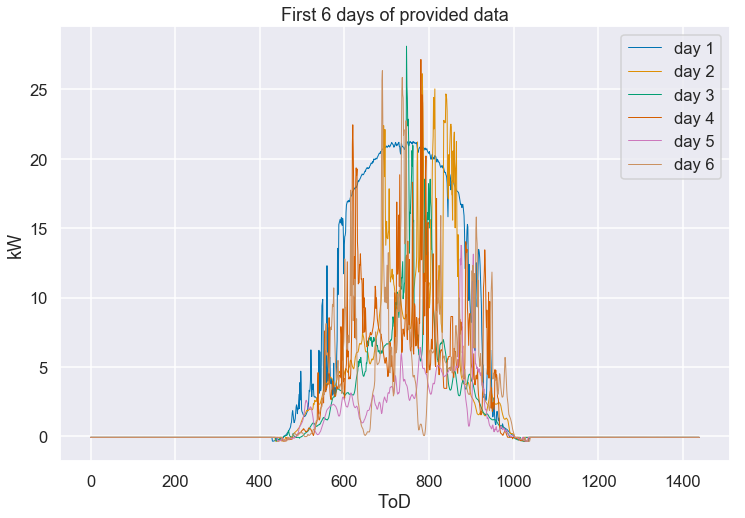

In [7]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.plot(data[:, i], linewidth=1, label='day {}'.format(i+1))
plt.legend()
plt.title('First {} days of provided data'.format(i+1))
plt.ylabel('kW')
plt.xlabel('ToD')
plt.show()

In [8]:
from statistical_clear_sky.solver_type import SolverType
iterative_fitting = IterativeFitting(data, rank_k=5, solver_type=SolverType.mosek)

In [9]:
u, sig, vt = np.linalg.svd(data)

In [10]:
iterative_fitting.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 33072447.452 [50277.444939679175, 2696.324801471715, 26705946.542505328, 6313527.140111118]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 39149.359 [3.3987613e+04 2.8009000e+01 5.1337370e+03 0.0000000e+00]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 33974.760 [28981.181    59.569  4934.01      0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 33450.414 [28452.83     75.187  4922.397     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 33328.932 [28335.876    78.527  4914.529     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 33247.814 [28258.675    80.165  4908.974     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 33188.263 [28207.272    82.799  4898.192     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 7: 33143.982 [28177.256    84.662  4882.063     0.   ]
Miminizing

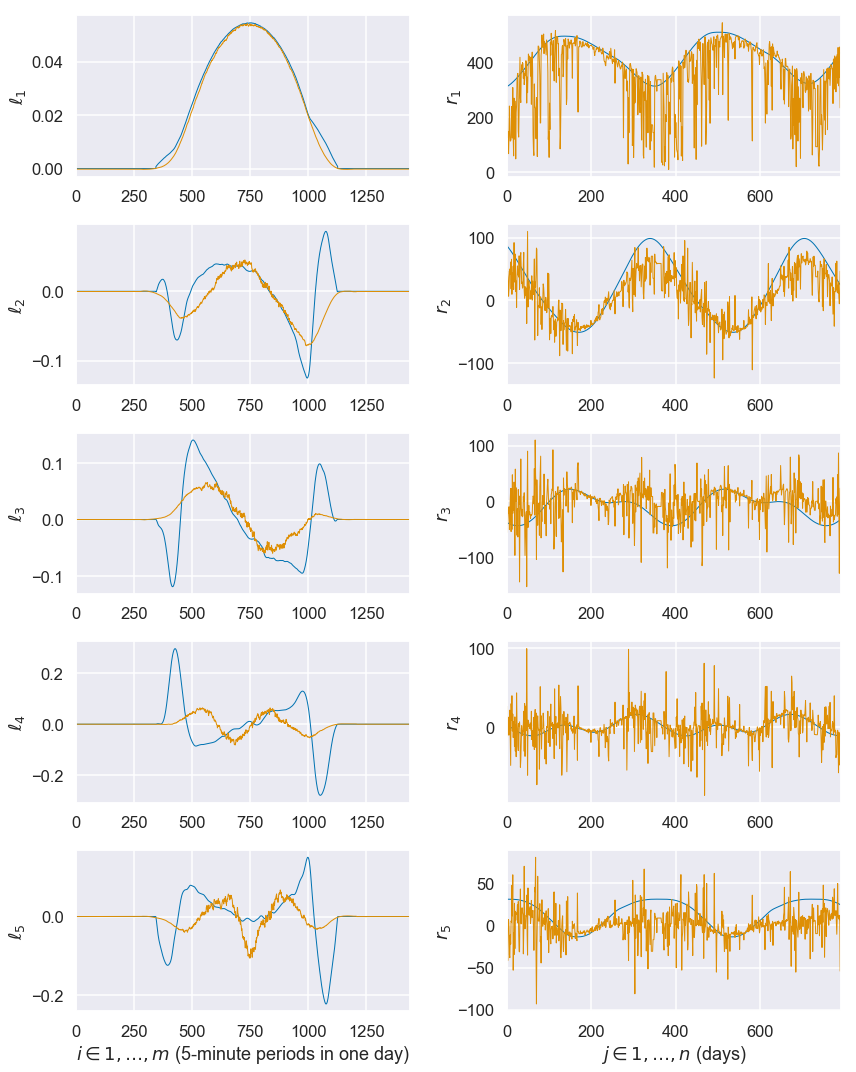

In [11]:
n=5
fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(12,n*3))
for i in range(n):
    ax[i][0].plot(iterative_fitting.l_cs_value.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 1439)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot(iterative_fitting.r_cs_value[i], linewidth=1)
    ax[i][1].set_xlim(0, data.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
    ax[i][0].plot(u.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 1439)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(sig).dot(vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, data.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

(0, 5760)

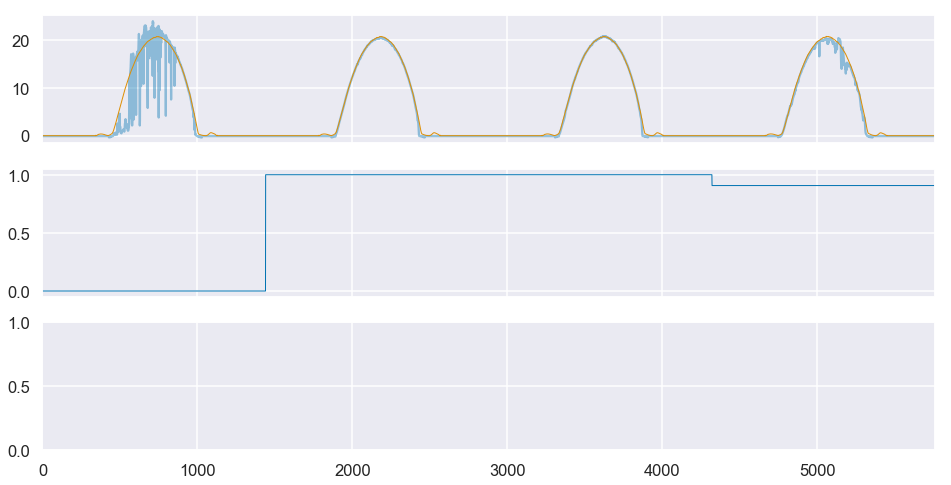

In [12]:
d1 = 350
d2 = d1 + 4
actual = data[:, d1:d2].ravel(order='F')
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 1440), linewidth=1)
ax[-1].set_xlim(0, 1440*(d2-d1))

Finally, we take a "top-down" view of the raw data used as an input to the algorithm, and the estimated clear sky signal returned by the algorithm.

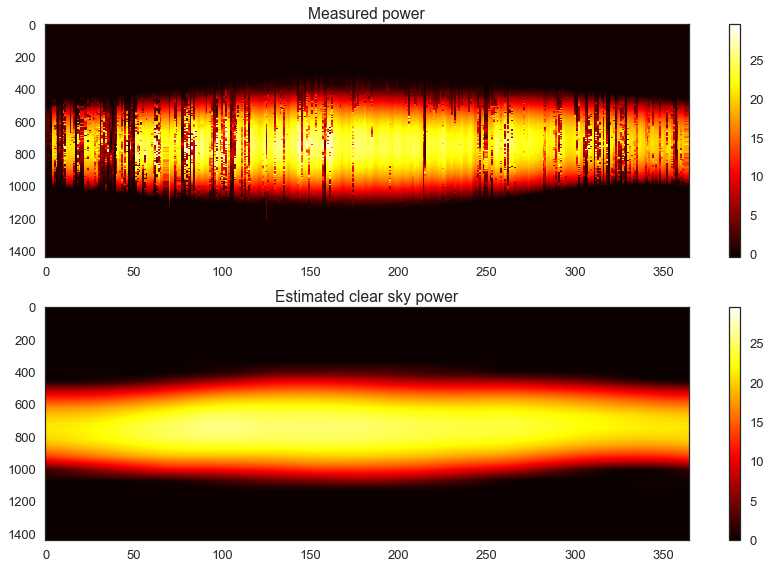

In [11]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(12,8))
    foo = ax[0].imshow(data, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot', vmin=0, vmax=np.max(data), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0])
    plt.colorbar(bar, ax=ax[1])
    plt.tight_layout()

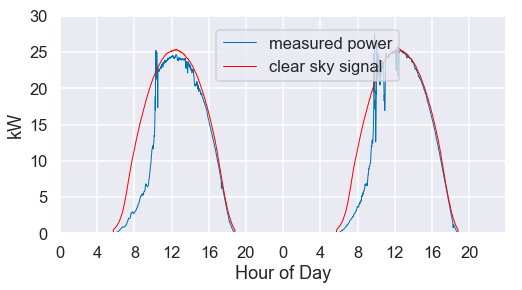

In [13]:
d1 = 130
d2 = d1 + 2
actual = p[d1*1440:d2*1440]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 1440*(d2-d1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 1440*2, 2*120))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
ax.set_ylim(0,30)
plt.show()

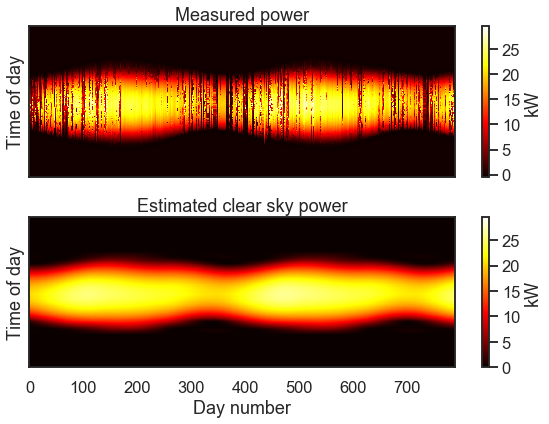

In [14]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(data, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot', vmin=0, vmax=np.max(data), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(0, 30, 5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

In [15]:
print(sum(iterative_fitting.l_cs_value.shape) + sum(iterative_fitting.r_cs_value.shape))

2240


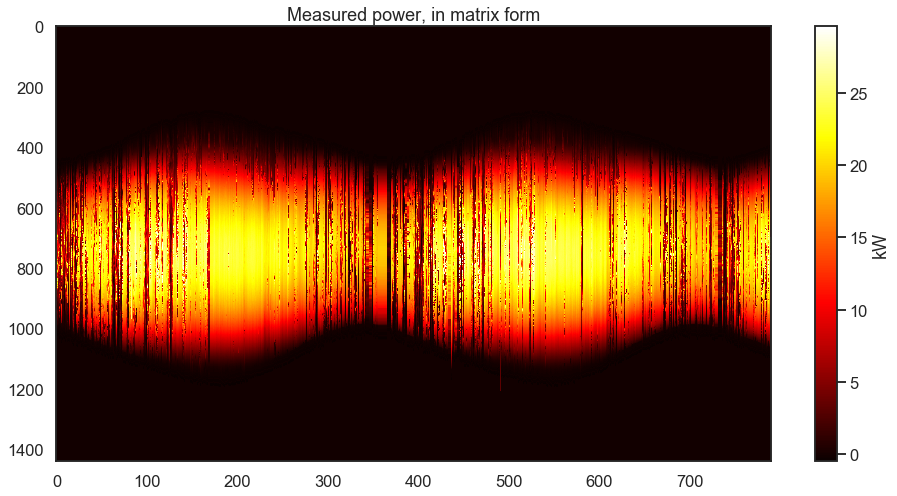

In [16]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(data, cmap='hot', aspect='auto', interpolation='none', vmax=np.max(data))
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')

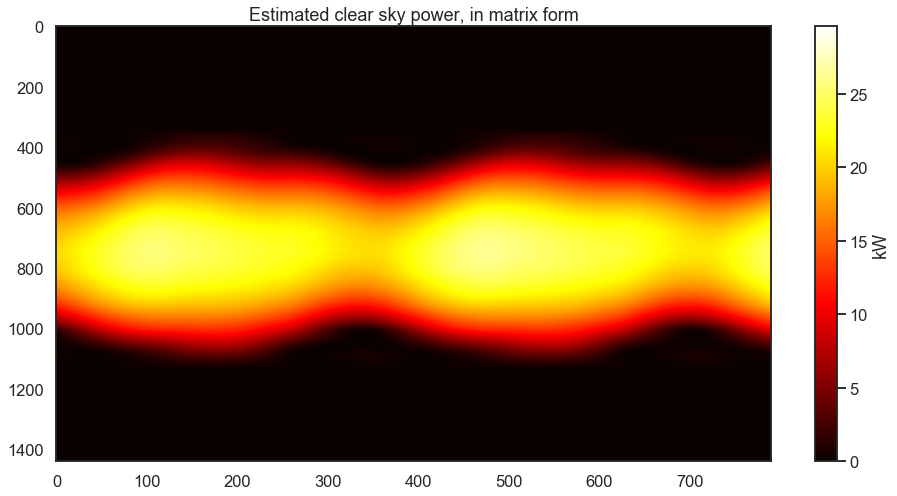

In [17]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(iterative_fitting.clear_sky_signals(), cmap='hot', aspect='auto', interpolation='none', vmax=np.max(data))
    plt.colorbar(label='kW')
    plt.title('Estimated clear sky power, in matrix form')